# ДЗ в конце ноутбука

# 1. Матричная факторизация

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентый фактор = эмбеддинг (embedding)    

<img src='mf.png'>

In [1]:
(UхI) = (Uхk) * (kхI)

NameError: name 'Uхk' is not defined

---

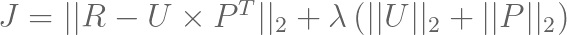

## Alternating Least Squares (ALS)

<img src="als_formula.png" >

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть регуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать просто перемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 1. Базовое применение

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [2]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [3]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [4]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [8]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/mrb/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
csr_matrix(user_item_matrix).tocsr()

<2499x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 667080 stored elements in Compressed Sparse Row format>

In [9]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [11]:
userid_to_id[1984]

1983

# ALS

In [12]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 52.3 s, sys: 1min 19s, total: 2min 11s
Wall time: 20.9 s


In [13]:
[id_to_itemid[rec[0]] for rec in recs]

[5569230, 1106523, 1133018, 999999, 1082185]

In [14]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [15]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 2min 45s, sys: 6min 24s, total: 9min 10s
Wall time: 1min 22s


0.16287952987267387

In [16]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 5569374, 979707, 1005186, 1051211]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 1022003, 951590, 952317]"


### Embeddings

In [17]:
model.item_factors.shape

(5001, 100)

In [18]:
pd.DataFrame(model.item_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.002998,0.003189,0.003350,0.003462,0.001889,0.003456,0.002990,0.000896,0.004362,0.001269,...,0.002100,0.001837,0.001177,0.004170,0.000089,0.002703,0.001647,0.002930,0.002552,0.003562
1,0.002664,0.003375,0.002834,0.003885,0.000437,0.002560,0.004636,0.001014,0.007804,0.007448,...,0.003109,0.001926,0.001505,0.006053,-0.006025,0.005002,0.007005,0.004503,0.005393,0.004810
2,0.002290,0.001480,0.001161,0.002707,0.002250,0.003976,0.003799,0.001943,0.005049,0.000736,...,0.003186,0.001243,0.003046,0.004492,0.000662,0.003821,0.004265,0.003959,0.003105,0.005777
3,0.002968,0.004644,0.003420,0.002716,0.001782,0.004043,0.003720,0.002144,0.003519,0.001186,...,0.003473,0.003173,0.001722,0.003689,0.001752,0.003003,0.002207,0.002770,0.003425,0.002785
4,0.002204,0.001987,0.002181,0.002208,0.001507,0.002277,0.001827,0.000815,0.002636,0.000860,...,0.001902,0.000987,0.001485,0.002381,0.000791,0.001639,0.001452,0.002066,0.001892,0.002344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.007858,-0.002672,0.014537,0.008875,0.002965,0.006179,0.006844,-0.000056,0.012770,0.009013,...,-0.000480,0.010056,0.007218,0.010028,0.001811,-0.000309,0.003812,0.009043,0.014375,0.008054
4997,0.002675,0.004495,0.004913,0.005565,0.005595,0.006444,0.005249,0.004702,0.004948,-0.002974,...,-0.000005,0.003235,0.007162,0.005734,0.008846,0.008482,0.000026,0.005029,0.003815,0.005769
4998,0.005520,0.008661,0.001732,0.004665,0.004186,0.002702,0.005530,0.003289,0.004895,0.001693,...,0.005674,0.000722,0.003986,0.012166,0.002819,0.002342,0.003759,0.008601,0.002022,0.006845
4999,0.005063,0.005682,0.002656,0.004012,0.007495,0.006475,0.004808,0.001135,0.007236,0.004041,...,0.004341,0.001839,0.009364,0.005501,0.004144,0.005645,0.005391,0.008167,0.004736,0.010240


In [19]:
model.user_factors.shape

(2499, 100)

In [20]:
pd.DataFrame(model.user_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.066308,-1.597712,-3.030129,-5.968803,0.343895,4.862360,-1.152087,1.645530,-0.776809,6.205089,...,1.337573,2.427352,0.533052,2.968224,0.986473,-2.642586,-2.490282,-2.813454,-0.279272,2.468903
1,-3.465006,-0.216546,-3.678471,-4.177052,-0.859281,3.154770,-3.907227,2.890297,-6.061151,10.004767,...,-3.717295,3.325013,-5.812666,1.109381,3.443730,-0.341712,-1.742846,-1.338744,-2.000855,-0.648779
2,-2.079109,-2.473057,-1.518643,-1.840472,-4.949548,6.127993,-3.284168,-3.123237,-2.589242,9.440777,...,-0.841895,3.110564,-0.853709,-0.567549,8.534215,-3.529135,-1.547386,-0.192239,-4.076482,-0.339493
3,-0.055463,2.359241,-5.565224,-4.025465,-2.005748,2.256362,-1.139852,-0.004120,-2.975243,4.293000,...,-1.704032,0.926263,-2.301028,1.130051,4.613556,-2.837305,-2.270041,-1.962582,-0.819906,2.128886
4,-2.732719,0.420303,-4.829611,-3.089136,-3.174963,4.105616,-3.043333,-0.831214,-2.583800,2.559557,...,-0.808282,-0.229875,-1.290578,0.387471,3.158155,-2.572035,-1.293858,-1.990608,-0.283519,0.478052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,-7.233738,0.109842,-2.156922,0.230180,-3.335218,3.187963,-2.633958,1.339439,-7.131128,11.026680,...,-5.447978,3.471134,3.958574,-8.483957,3.868711,-7.114367,-3.390748,2.163664,-0.853712,1.076488
2495,-12.649380,-4.608616,-1.799055,-4.184807,6.566508,-1.051356,-2.745112,0.577336,3.184110,4.982662,...,0.411999,2.617689,-3.188409,2.646795,2.314780,3.684979,4.224611,5.466267,-1.277316,-2.763876
2496,-1.051005,-0.100952,-5.758532,-2.095774,-4.404047,3.800210,-1.894894,0.151707,-3.446415,2.149753,...,-1.548473,3.260644,-2.047803,-0.151699,-1.905956,0.134610,-4.141455,-3.407350,0.896361,1.229444
2497,-1.656675,-7.333362,-6.279440,2.113751,0.038334,0.500301,-4.766213,1.206139,-5.303557,6.630820,...,0.634064,4.247164,-2.190509,-0.639923,7.719507,-1.731724,1.547029,0.236858,-0.986019,-2.794032


Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [21]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [22]:
pd.DataFrame(fast_recs)

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,-0.008120,0.086834,0.026204,0.004263,0.001293,0.010340,0.010505,0.151099,0.161774,-0.078381,...,0.154127,0.067662,0.271834,0.065128,0.297223,0.197578,-0.119230,0.054611,0.000386,-0.138339
1,0.008017,0.109485,-0.016354,0.005054,-0.000570,-0.003503,-0.008623,0.044551,0.131675,-0.026982,...,0.036556,0.018668,-0.000503,0.063503,0.088927,0.087055,0.050791,-0.066329,0.102568,0.028956
2,-0.012980,-0.035722,-0.036668,-0.027115,-0.010173,-0.024139,-0.035829,0.083416,-0.055524,0.039828,...,-0.021292,-0.015399,0.264194,0.266928,0.162683,0.297303,0.082271,-0.070813,0.063164,0.005786
3,0.008029,0.058859,0.021374,0.040153,0.005679,0.009687,-0.003410,0.120271,0.031897,0.011813,...,0.054887,0.064233,0.013339,-0.003441,0.018987,0.074481,0.051468,0.080097,0.011649,0.063409
4,-0.001297,0.039243,-0.004992,0.030563,0.001931,0.000647,0.001548,0.011549,0.037519,0.018084,...,0.008853,0.005346,0.000069,0.077153,0.035538,-0.037429,0.049539,-0.027038,0.016803,-0.014458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.015511,0.101521,0.071947,0.016215,0.009138,0.025875,-0.000874,0.111557,-0.034144,-0.073848,...,0.136628,-0.035162,0.118064,0.119537,0.128445,0.303400,0.070546,-0.054425,0.220668,0.132058
2495,0.017997,0.188968,0.084544,-0.047343,0.008930,0.020467,0.034397,0.093690,0.140097,0.225683,...,-0.097046,0.320035,0.126388,0.071343,0.173171,0.127796,0.074663,-0.005570,0.082666,0.065204
2496,0.055076,0.081581,0.008333,0.025284,0.005311,0.005702,0.014577,-0.084934,-0.051292,0.025406,...,0.076933,0.101478,0.058777,0.141319,0.186309,0.233468,0.062438,0.041315,0.058271,0.073214
2497,-0.032791,0.070296,-0.011935,-0.052463,-0.015272,-0.023081,-0.000125,0.126087,0.249688,0.040054,...,-0.061935,0.013923,0.095987,-0.034204,0.125811,0.115032,0.175736,-0.043298,0.077426,0.309330


In [23]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [24]:
model.item_factors.shape

(5001, 100)

In [25]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [26]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


/home/mrb/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


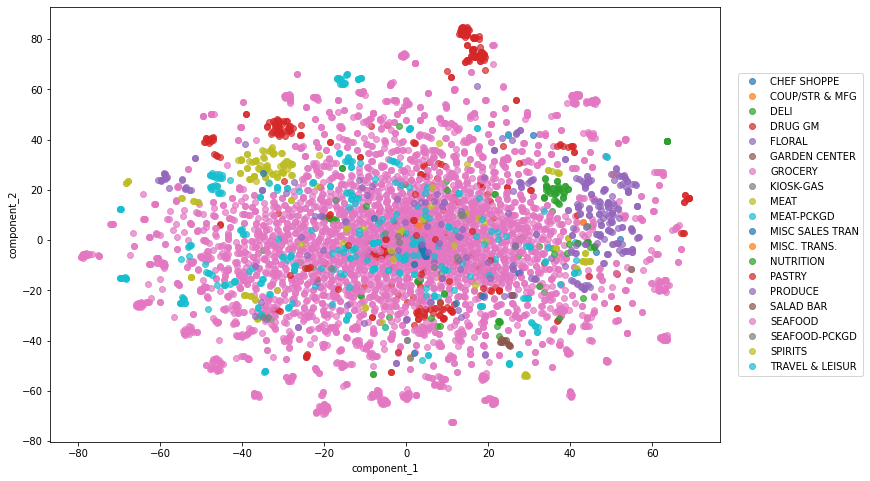

CPU times: user 7min 38s, sys: 3.14 s, total: 7min 41s
Wall time: 1min 13s


In [27]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

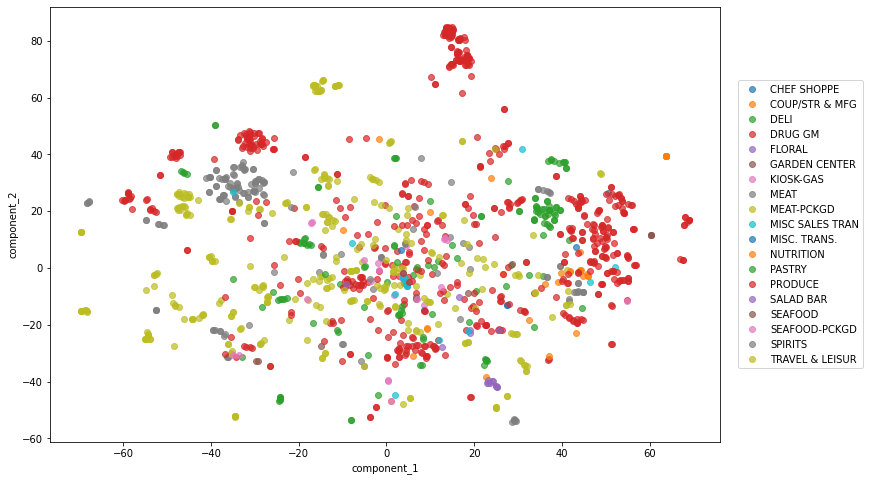

In [28]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

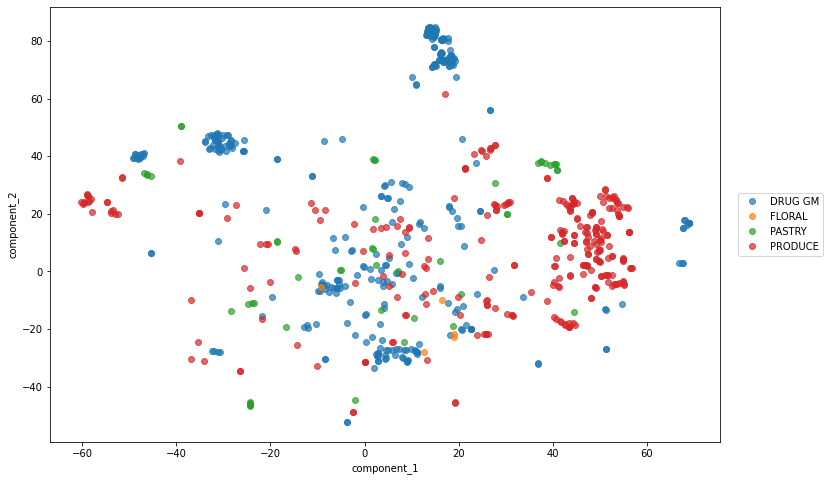

In [29]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

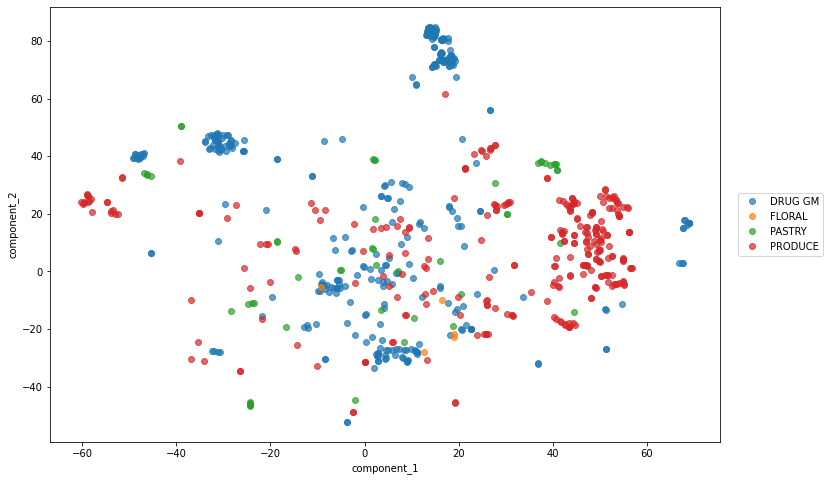

In [30]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

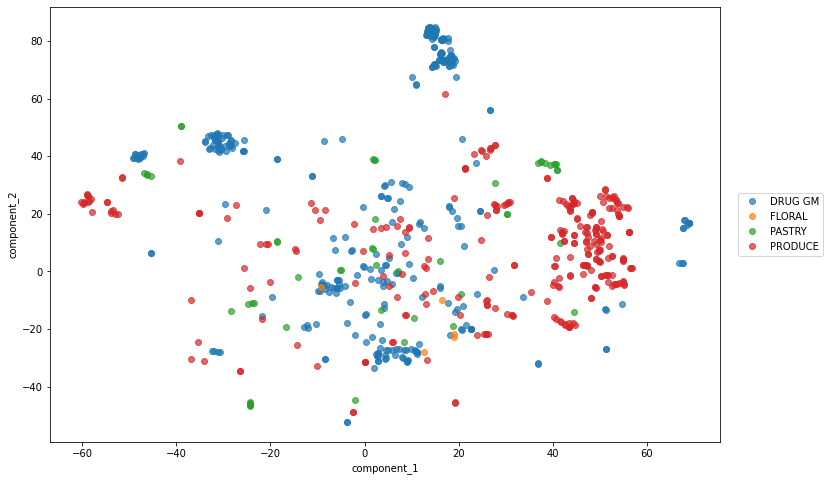

In [31]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [32]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,3.845451,-3.407541,MISC SALES TRAN
1,8.532861,-13.127730,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [33]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 3min 19s, sys: 7min 23s, total: 10min 43s
Wall time: 1min 41s


In [34]:
recommendations.shape

(2499, 5)

In [35]:
pd.DataFrame(recommendations)

,0,1,2,3,4
0,3031,192,3616,1242,2696
1,4346,2148,391,1516,2319
2,1516,3388,1242,558,3029
3,3408,1801,3587,110,2148
4,3408,2148,3133,2307,4346
...,...,...,...,...,...
2494,2434,1923,1029,2472,195
2495,225,1242,777,647,2765
2496,3133,4346,3587,2307,2148
2497,2847,300,657,1908,2572


In [36]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [37]:
item_1.shape

(100,)

In [38]:
item_1

array([ 2.6640876e-03,  3.3752352e-03,  2.8343066e-03,  3.8847940e-03,
        4.3729370e-04,  2.5596227e-03,  4.6363096e-03,  1.0144198e-03,
        7.8040729e-03,  7.4477876e-03,  7.9677524e-03,  1.3392136e-03,
        3.2101325e-03, -2.1913999e-03,  3.3138269e-03,  3.2143174e-03,
        3.6681385e-03,  5.9707309e-03,  3.5795469e-03,  4.1149040e-03,
        8.4008259e-04,  3.7516411e-03,  3.9973571e-03,  6.7270971e-03,
        9.3880212e-03,  3.7256321e-03,  3.2624016e-03,  5.1893550e-03,
        1.7435217e-03,  7.0379791e-03,  6.4886515e-03,  4.5430074e-03,
        5.9705270e-03,  3.6575340e-04,  6.4141117e-03,  6.1295321e-03,
        6.5015168e-03,  7.6832874e-03, -4.1074876e-05,  8.9194356e-03,
        1.9496788e-03,  3.1157103e-03,  9.2655336e-03,  7.1766782e-03,
        7.2035226e-03, -5.6045892e-04,  6.0747447e-03,  2.7672357e-03,
        2.7364048e-03,  3.5059177e-03,  6.3934145e-03,  8.6304611e-03,
        4.0468797e-03,  3.6943611e-03,  2.5610924e-03,  1.1862753e-03,
      

*Посмотрите также / Похожие товары*

In [39]:
example_item_row_id = 3606

In [40]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [41]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
8143,839040,942,GROCERY,National,CONDIMENTS/SAUCES,HOT MUSTARD/SPECIALTY MUSTAR,12 OZ
25270,990804,69,GROCERY,Private,VEGETABLES - SHELF STABLE,MUSHROOMS CND & GLASS,4.5 OZ
25391,991844,213,GROCERY,National,MEAT - SHELF STABLE,POTTED MEATS AND SPREADS,3OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
41452,1135476,673,PRODUCE,National,BERRIES,STRAWBERRIES,1 LB


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [42]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0),
 (239, 0.9756397),
 (354, 0.9745992),
 (790, 0.9731363),
 (1380, 0.97178465)]

### 2. TF-IDF взвешивание

In [43]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [44]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 3min 36s, sys: 7min 57s, total: 11min 33s
Wall time: 1min 43s


0.16405484818805094

### 3. BM25 взвешивание

In [45]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/mrb/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [47]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 3min 40s, sys: 7min 51s, total: 11min 32s
Wall time: 1min 42s


In [48]:
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.1932419196865818

In [49]:
result

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 5569374, 979707, 1005186, 1051211]","[1027569, 1033142, 986912, 1100972, 821083]","[999999, 995242, 1082185, 965766, 1100972]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 1022003, 951590, 952317]","[951590, 1133018, 1106523, 999999, 883404]","[999999, 1133018, 951590, 1106523, 1053690]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1051516, 1007195, 878996, 923746, 986912]","[878996, 1051516, 1024306, 866211, 1127831]","[1082185, 1023720, 1024306, 1007195, 1051516]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[999999, 1082185, 1058997, 826249, 1133018]","[999999, 1082185, 1126899, 1106523, 938700]","[999999, 1082185, 6944571, 828867, 1058997]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1068719, 938700, 1053690, 1004906, 965766]","[1053690, 965766, 938700, 979707, 1133018]","[999999, 840361, 1068719, 883404, 826249]"
...,...,...,...,...,...
2037,2496,[6534178],"[914190, 1071939, 1077555, 1133018, 1013321]","[914190, 1133018, 840361, 847982, 1106523]","[999999, 914190, 1133018, 831628, 1070702]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[5569230, 957951, 5569845, 5585510, 883404]","[5569230, 951590, 5569471, 957951, 883932]","[5569230, 999999, 5569845, 995785, 904360]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[999999, 1053690, 862349, 9526410, 1070820]","[999999, 1082185, 6534178, 1053690, 862349]","[999999, 6534178, 995242, 862349, 840361]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[6534178, 1004906, 938700, 1038217, 840361]","[826249, 883404, 929668, 6534178, 1004906]","[999999, 883404, 1098066, 826249, 5569845]"


In [50]:
result.to_csv('predictions_mf.csv', index=False)  # mf - matrix factorization

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [51]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [52]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

/tmp/ipykernel_64739/1027606932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


499.99

# ДЗ

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

4) Поэкспериментировать с ALS (grid-search)

In [145]:
def prefilter_items(data, category: list):
    # Уберем самые популярные товары (их и так купят)
#     может я чего не догоняю, но мне не нравится вариант, что item_id тоже делится, поэтому предлагаю коррекция кода: вместо
#     popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
#     вот это:
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index()
    popularity['user_id'] = popularity['user_id'] / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    last_week = data_train.groupby('item_id')['week_no'].max().reset_index()
    last_week = last_week.loc[last_week['week_no'] < data_train['week_no'].max() - 52].item_id.tolist()
    data = data[~data['item_id'].isin(last_week)]
    
    # Уберем не интересные для рекоммендаций категории (department)
    # всвяязи с тем, что не очень понятно какие категории нам не интересны просто добавил передаваемый в функцию
    # аргумент со списком категорий, товары из которых нужно откинуть
    non_interesting_cat_item = item_features['item_id'].loc[item_features['department'].isin(category)].tolist()
    data = data[~data['item_id'].isin(non_interesting_cat_item)]
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    # по курсу на 2 янв 60 руб = 0.8 usd
    price_ = data_train.groupby('item_id')['price'].max().reset_index()
    low_price = price_.loc[price_['price'] < 0.8].item_id.tolist()
    data = data[~data['item_id'].isin(low_price)]
    
    # Уберем слишком дорогие товары
    # пожалуй стоит убрать все, что дороже 80 usd (аккурат 6000 руб)
    high_price = price_.loc[price_['price'] > 80].item_id.tolist()
    data = data[~data['item_id'].isin(high_price)]
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *utils.py*

In [120]:
%%time

factors_ = [50, 100, 150, 200]
regul_ = [1e-4, 1e-3, 1e-2, 1e-1]
iter_ = [5, 10, 15, 20, 25]
result_table = {}
for factor in factors_:
    for regul in regul_:
        for itr in iter_:
            model = AlternatingLeastSquares(factors=factor, 
                                            regularization=regul,
                                            iterations=itr, 
                                            calculate_training_loss=True, 
                                            num_threads=4)

            model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                      show_progress=True)
            result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            score = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
            result_table[(factor, regul, itr)] = score

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 4h 17min 55s, sys: 10h 1min 23s, total: 14h 19min 18s
Wall time: 1h 54min 9s


In [137]:
pd.DataFrame(data=result_table, index=range(len(result_table))).max(axis=0)

50   0.0001  5     0.176004
             10    0.174633
             15    0.169442
             20    0.173751
             25    0.176885
                     ...   
200  0.1000  5     0.205289
             10    0.199804
             15    0.197551
             20    0.199510
             25    0.196082
Length: 80, dtype: float64

Наилучший результат после поиска по сетке получается при параметрах: 200 факторов, регуляризация 0.1, 5 итераций

Очень долго тупил над этим заданием, поэтому уже делаю как получится))

Из-за разношерстности товаров для рекомендации (акционные, новые и для повышения среднего чека) придется либо делать обширный список рекомендаций и делать постфильтрацию либо делать три разные модели с тремя разными дополнительными префильтрами (помимо основного, который уже написан), ну или я где-то перестал понимать тему от слова совсем и у меня кончилась фантазия))

По акционным товарам: если использовать user-item матрицу в том виде, как было на уроке, то изменение скидки никак не отобразится на результате т.к. сводная таблица строилась на основании количества купленного товара.
Тут конечно нужно уточнение от менеджеров по поводу скидок, но в общем случае, как я понимаю скидки в минус себе не делают, значит их можно использовать в качестве веса для формирования user-item матрицы (но только для акционных товаров, потому что неакционные товары просто занулит) к примеру значение из изначальной матрицы домножаем на abs(log(1-размер скидки)) (можно и просто на размер скидки, но тогда значение будет ниже, тогда этот вариант предпочтительней, если не хочется излишний вес давать большим скидкам) - тогда мы получаем 0 в случае отсутствия скидки и в остальных случаях значение будет тем больше, чем больше скидка (с поправкой на количество приобретенного товара). Ведь если скидка на товар большая, значит продавец хочет быстрей продать этот товар, почему бы не попробовать этому поспособствовать, да и пользователи будут рады большой скидке. Если в матрицу просто загонять скидку без привязки к количеству товара, то в рекомендации будут постоянно попадать товары с самой большой скидкой, что тоже, на мой взгляд, неверно.

По новому товару: если просто фильтровать аутлут ALS, то действительно можно напороться на низкую вероятность покупки, возможно лучше будет отфильтровать категорию, в которой у юзера больше всего покупок и сделать рекомендацию нового товара из этой категории, возможно это поможет поднять метрику (только получается проблемка, а что если и этот товар по акции? не будет ли это противоречить ТЗ?)

По товару для повышения среднего чека: возможно есть смысл ориентироваться на значение 97-98 перцентиля - однозначно то, что выше этого будет дороже, чем он покупает обычно, но может даже пойдет значение 9-го дециля + 10-15%. В общем вопрос сложный - тут только эксперименты и опыт подскажут как мне кажется))

# Links

BM25

https://en.wikipedia.org/wiki/Okapi_BM25#:~:text=BM25%20is%20a%20bag%2Dof,slightly%20different%20components%20and%20parameters.


Matrix factorization (ALS, SVD)
https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/